In [1]:
!pip install --no-index -U --find-links=/kaggle/input/deeptables-dependecies deeptables==0.2.5

Looking in links: /kaggle/input/deeptables-dependecies
Processing /kaggle/input/deeptables-dependecies/deeptables-0.2.5-py3-none-any.whl
Processing /kaggle/input/deeptables-dependecies/hypernets-0.3.1-py3-none-any.whl (from deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/XlsxWriter-3.1.9-py3-none-any.whl (from hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/paramiko-3.4.0-py3-none-any.whl (from hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/bcrypt-4.1.2-cp39-abi3-manylinux_2_28_x86_64.whl (from paramiko->hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/PyNaCl-1.5.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (from paramiko->hypernets>=0.2.5.1->deeptables==0.2.5)


In [ ]:
# !pip install statsmodels

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import math
import numpy as np 
import pandas as pd 
import polars as pl 
import matplotlib.pyplot as plt 
import seaborn as sns
import holidays
import lightgbm as lgb
import tensorflow as tf, deeptables as dt
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW
from tensorflow.python.keras import backend as K
from deeptables.models import DeepTable, ModelConfig
from deeptables.models import deepnets
import joblib
from datetime import timedelta

print('Tensorflow version:', tf.__version__)
print('DeepTables version:', dt.__version__)

# fast ai libraries
from fastai.tabular.all import *

# constants
SEED = 2024 # global seed for notebook
BATCH_SIZE = 1024
EPOCHS = 20

#library from Yelim
from statsmodels.tsa.stattools import acf, pacf
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Tensorflow version: 2.13.0
DeepTables version: 0.2.5


In [3]:
import gc
import ctypes

seed = 42
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(seed=seed)

def clean_memory():
    gc.collect()
    ctypes.CDLL("libc.so.6").malloc_trim(0)
clean_memory()


In [4]:
class DataStorage:
    """
    This class was copied out from:
    https://www.kaggle.com/code/vitalykudelya/enefit-object-oriented-gbdt
    """
    
    root = "/kaggle/input/predict-energy-behavior-of-prosumers"

    data_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
        "row_id",
        "prediction_unit_id",
    ]
    client_cols = [
        "product_type",
        "county",
        "eic_count",
        "installed_capacity",
        "is_business",
        "date",
    ]
    gas_prices_cols = ["forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]
    electricity_prices_cols = ["forecast_date", "euros_per_mwh"]
    forecast_weather_cols = [
        "latitude",
        "longitude",
        "hours_ahead",
        "temperature",
        "dewpoint",
        "cloudcover_high",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "forecast_datetime",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
    historical_weather_cols = [
        "datetime",
        "temperature",
        "dewpoint",
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "windspeed_10m",
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
        "latitude",
        "longitude",
    ]
    location_cols = ["longitude", "latitude", "county"]
    target_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
    ]

    def __init__(self):
        self.df_data = pl.read_csv(
            os.path.join(self.root, "train.csv"),
            columns=self.data_cols,
            try_parse_dates=True,
        )
        self.df_client = pl.read_csv(
            os.path.join(self.root, "client.csv"),
            columns=self.client_cols,
            try_parse_dates=True,
        )
        self.df_gas_prices = pl.read_csv(
            os.path.join(self.root, "gas_prices.csv"),
            columns=self.gas_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = pl.read_csv(
            os.path.join(self.root, "electricity_prices.csv"),
            columns=self.electricity_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = self.df_electricity_prices.with_columns(
            self.df_electricity_prices['euros_per_mwh'].abs().alias('euros_per_mwh')
        )
        self.df_forecast_weather = pl.read_csv(
            os.path.join(self.root, "forecast_weather.csv"),
            columns=self.forecast_weather_cols,
            try_parse_dates=True,
        )
        self.df_historical_weather = pl.read_csv(
            os.path.join(self.root, "historical_weather.csv"),
            columns=self.historical_weather_cols,
            try_parse_dates=True,
        )
        self.df_weather_station_to_county_mapping = pl.read_csv(
            os.path.join(self.root, "weather_station_to_county_mapping.csv"),
            columns=self.location_cols,
            try_parse_dates=True,
        )
        self.df_data = self.df_data.filter(
            pl.col("datetime") >= pd.to_datetime("2022-01-01")
        )
        self.df_target = self.df_data.select(self.target_cols)

        self.schema_data = self.df_data.schema
        self.schema_client = self.df_client.schema
        self.schema_gas_prices = self.df_gas_prices.schema
        self.schema_electricity_prices = self.df_electricity_prices.schema
        self.schema_forecast_weather = self.df_forecast_weather.schema
        self.schema_historical_weather = self.df_historical_weather.schema
        self.schema_target = self.df_target.schema

        self.df_weather_station_to_county_mapping = (
            self.df_weather_station_to_county_mapping.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
        )
        
    def run(self):
        self.df_data = self.fill_target(self.df_data)
        self.df_forecast_weather = self.fill_radiation(self.df_forecast_weather)
        self.df_forecast_weather = self.fill_summertime(self.df_forecast_weather)
        self.df_forecast_weather = self.separateTP(self.df_forecast_weather)
        self.df_forecast_weather = self.expForecastHr(self.df_forecast_weather)
        self.df_forecast_weather = self.snow2water(self.df_forecast_weather)
#         self.df_historical_weather = self.histRoll(self.df_historical_weather)
        
        return self
    
    def run_test(self):
        #self.df_data = self.fill_target(self.df_data)
        self.df_forecast_weather = self.separateTP(self.df_forecast_weather)
        self.df_forecast_weather = self.expForecastHr(self.df_forecast_weather)
        self.df_forecast_weather = self.snow2water(self.df_forecast_weather)
#         self.df_historical_weather = self.histRoll(self.df_historical_weather)
        
        return self
    
        
    def fill_target(self, df):
        def _interpolate_group(group):
            group['target'] = group['target'].interpolate(method='linear')
            return group
        return pl.DataFrame(df.to_pandas().groupby(['prediction_unit_id', 'is_consumption']).apply(_interpolate_group))

    def fill_radiation(self, df):
        rad = df.to_pandas()['surface_solar_radiation_downwards'].values
        idx = df['surface_solar_radiation_downwards'].is_null().to_numpy().nonzero()[0]
        for i, ind in enumerate(idx):
            tmp = df[idx][i]
            df_b1 = df.filter(
                pl.col('latitude') == tmp['latitude'], 
                pl.col('longitude') == tmp['longitude'],
                abs(pl.col('forecast_datetime') - tmp['forecast_datetime']) < timedelta(days=2),
                pl.col('forecast_datetime').dt.hour() == tmp['forecast_datetime'].dt.hour(),
                pl.col('hours_ahead') == tmp['hours_ahead'])

            # 결측값 검사 및 안전한 나눗셈
            if df_b1['direct_solar_radiation'][0] is not None and df_b1['surface_solar_radiation_downwards'][0] not in [None, 0] \
               and df_b1['direct_solar_radiation'][2] is not None and df_b1['surface_solar_radiation_downwards'][2] not in [None, 0]:
                fillValue = df_b1['direct_solar_radiation'][1] / ((np.divide(df_b1['direct_solar_radiation'][0], df_b1['surface_solar_radiation_downwards'][0]) +
                    np.divide(df_b1['direct_solar_radiation'][2], df_b1['surface_solar_radiation_downwards'][2]))/2)
                rad[ind] = fillValue
            else:
                rad[ind] = 0  # 결측값 대체를 위한 기본값 설정

        df.replace('surface_solar_radiation_downwards', pl.Series(rad))
        return df


    def fill_summertime(self, df):
        missingDate = list(set(pd.date_range('2021-09-01', '2023-06-02', freq='h')[3:-22]) - set(df.to_pandas()['forecast_datetime'].unique()))
        hrs_ahead = 2
        add_df = pd.DataFrame()
        for date in missingDate:
            tmp = df.filter(abs(pl.col('forecast_datetime') - date) < timedelta(hours=2),
                            pl.col('hours_ahead') <= 2).sort('latitude', 'longitude').to_pandas()
            values_1 = None  # 초기화
            for _, row in tmp.iterrows():
                if row['hours_ahead'] == 1:
                    values_1 = row
                elif row['hours_ahead'] == 2 and values_1 is not None:
                    values_2 = row
                    average_values = pd.Series([(v1+v2)/2 if c != 'forecast_datetime' else date for (v1,v2,c) in zip(values_1,values_2,values_2.keys())],
                                            index=values_2.keys())
                    average_values['hours_ahead'] = hrs_ahead
                    add_df = pd.concat([add_df, average_values.to_frame().T]).reset_index(drop=True)
        return pl.DataFrame(pd.concat([df.to_pandas(), add_df]).reset_index(drop=True))


    def snow2water(self, df): # for historical: [cm]/7->[mm]
        return df.with_columns(
            (df['snowfall']/7).alias('snowfall_mm'))

    def separateTP(self, df): 
    # Adjust the indentation as needed to match the rest of your class
        df = df.with_columns([
            (df['total_precipitation'] - df['snowfall'] / 100).alias('rain')
        ])
        return df

    def expForecastHr(self, df):
    # Ensure the indentation here matches the rest of your class
        def _exp(x):
            return np.exp(x) / np.exp(48)

        df = df.with_columns([
            df['hours_ahead'].apply(_exp).alias('exp_hours_ahead')
        ])
        return df
    
#     def histRoll(self, df): # roll -1hr, for only T & T_d
#         df = df.with_columns([
#             df['temperature'].shift(-1).alias('temperature')
#         ])
#         df = df.with_columns([
#             df['dewpoint'].shift(-1).alias('dewpoint')
#         ])
#         return df

    def update_with_new_data(
        self,
        df_new_client,
        df_new_gas_prices,
        df_new_electricity_prices,
        df_new_forecast_weather,
        df_new_historical_weather,
        df_new_target,
    ):
        
        df_new_client = pl.from_pandas(
            df_new_client[self.client_cols], schema_overrides=self.schema_client
        )
        df_new_gas_prices = pl.from_pandas(
            df_new_gas_prices[self.gas_prices_cols],
            schema_overrides=self.schema_gas_prices,
        )
        df_new_electricity_prices = pl.from_pandas(
            df_new_electricity_prices[self.electricity_prices_cols],
            schema_overrides=self.schema_electricity_prices,
        )
        df_new_forecast_weather = pl.from_pandas(
            df_new_forecast_weather[self.forecast_weather_cols],
            schema_overrides=self.schema_forecast_weather,
        )
        
        df_new_forecast_weather = self.separateTP(df_new_forecast_weather)
        df_new_forecast_weather = self.expForecastHr(df_new_forecast_weather)
        df_new_forecast_weather = self.snow2water(df_new_forecast_weather)

        df_new_historical_weather = pl.from_pandas(
            df_new_historical_weather[self.historical_weather_cols],
            schema_overrides=self.schema_historical_weather,
        )
        df_new_target = pl.from_pandas(
            df_new_target[self.target_cols], schema_overrides=self.schema_target
        )

        self.df_client = pl.concat([self.df_client, df_new_client]).unique(
            ["date", "county", "is_business", "product_type"]
        )
        self.df_gas_prices = pl.concat([self.df_gas_prices, df_new_gas_prices]).unique(
            ["forecast_date"]
        )
        self.df_electricity_prices = pl.concat(
            [self.df_electricity_prices, df_new_electricity_prices]
        ).unique(["forecast_date"])
        self.df_forecast_weather = pl.concat(
            [self.df_forecast_weather, df_new_forecast_weather]
        ).unique(["forecast_datetime", "latitude", "longitude", "hours_ahead"])
        self.df_historical_weather = pl.concat(
            [self.df_historical_weather, df_new_historical_weather]
        ).unique(["datetime", "latitude", "longitude"])
        self.df_target = pl.concat([self.df_target, df_new_target]).unique(
            ["datetime", "county", "is_business", "product_type", "is_consumption"]
        )

    def preprocess_test(self, df_test):
        df_test = df_test.rename(columns={"prediction_datetime": "datetime"})
        df_test = pl.from_pandas(
            df_test[self.data_cols[1:]], schema_overrides=self.schema_data
        )
        return df_test

In [5]:
class FeaturesGenerator:
    """
    This class was copied out from:
    https://www.kaggle.com/code/vitalykudelya/enefit-object-oriented-gbdt
    """
    def __init__(self, data_storage):
        self.data_storage = data_storage

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            #.filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )
        
        for hours_lag in [0]: # 7 * 24]:
            df_features = df_features.join(
#                 df_forecast_weather_date,
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast", #_{hours_lag}h",
            )
            df_features = df_features.join(
#                 df_forecast_weather_local,
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local", #_{hours_lag}h",
            )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )


        for hours_lag in [0]: #[2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical", #_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local", #_{hours_lag}h",
            )

#         for hours_lag in [0]: #[1 * 24]:
#             df_features = df_features.join(
#                 df_historical_weather_date.with_columns(
#                     pl.col("datetime") #+ pl.duration(hours=hours_lag),
#                     pl.col("datetime").dt.hour().alias("hour"),
#                 )
#                 #.filter(pl.col("hour") <= 10)
#                 .drop("hour"),
#                 on="datetime",
#                 how="left",
#                 suffix=f"_historical_{hours_lag}h",
#             )

        return df_features

#     def _add_target_features(self, df_features):
#         df_target = self.data_storage.df_target

#         df_target_all_type_sum = (
#             df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
#             .sum()
#             .drop("product_type")
#         )

#         df_target_all_county_type_sum = (
#             df_target.group_by(["datetime", "is_business", "is_consumption"])
#             .sum()
#             .drop("product_type", "county")
#         )

#         for hours_lag in [
#             2 * 24,
#             3 * 24,
#             4 * 24,
#             5 * 24,
#             6 * 24,
#             7 * 24,
#             8 * 24,
#             9 * 24,
#             10 * 24,
#             11 * 24,
#             12 * 24,
#             13 * 24,
#             14 * 24,
#             6,      ###
#             12,     ###
#             84,     ###
#             3096,   ### add juwon
#         ]:
#             df_features = df_features.join(
#                 df_target.with_columns(
#                     pl.col("datetime") + pl.duration(hours=hours_lag)
#                 ).rename({"target": f"target_{hours_lag}h"}),
#                 on=[
#                     "county",
#                     "is_business",
#                     "product_type",
#                     "is_consumption",
#                     "datetime",
#                 ],
#                 how="left",
#             )

#         for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
#             df_features = df_features.join(
#                 df_target_all_type_sum.with_columns(
#                     pl.col("datetime") + pl.duration(hours=hours_lag)
#                 ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
#                 on=["county", "is_business", "is_consumption", "datetime"],
#                 how="left",
#             )

#             df_features = df_features.join(
#                 df_target_all_county_type_sum.with_columns(
#                     pl.col("datetime") + pl.duration(hours=hours_lag)
#                 ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
#                 on=["is_business", "is_consumption", "datetime"],
#                 how="left",
#                 suffix=f"_all_county_type_sum_{hours_lag}h",
#             )

#         cols_for_stats = [
#             f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
#         ]
#         df_features = df_features.with_columns(
#             df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
#             df_features.select(cols_for_stats)
#             .transpose()
#             .std()
#             .transpose()
#             .to_series()
#             .alias(f"target_std"),
#         )

#         for target_prefix, lag_nominator, lag_denomonator in [
#             ("target", 24 * 7, 24 * 14),
#             ("target", 24 * 2, 24 * 9),
#             ("target", 24 * 3, 24 * 10),
#             ("target", 24 * 2, 24 * 3),
#             ("target_all_type_sum", 24 * 2, 24 * 3),
#             ("target_all_type_sum", 24 * 7, 24 * 14),
#             ("target_all_county_type_sum", 24 * 2, 24 * 3),
#             ("target_all_county_type_sum", 24 * 7, 24 * 14),
#         ]:
#             df_features = df_features.with_columns(
#                 (
#                     pl.col(f"{target_prefix}_{lag_nominator}h")
#                     / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
#                 ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
#             )

#         return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
           "datetime", "hour", "dayofyear"
        )
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features

    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        ).with_columns(pl.col("datetime").dt.cast_time_unit("us").alias("datetime"))

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            #self._add_target_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)

        return df_features

In [6]:
def convert_2_dataloader(df, _seed):

    # define categorical and continous numerical feature column names (on small number of features)
    # from train.csv
    cat_names = ["county", "is_business", "product_type", "is_consumption", "segment"]
    # from datetime column
    cat_names += ["weekday", "month", 'sin(dayofyear)', 'cos(dayofyear)', 'sin(hour)', 'cos(hour)']
    # from https://www.kaggle.com/code/albansteff/enefit-estonian-holidays-lb-65-79 notebook
    cat_names += ['country_holiday']
    
    # from client.csv
    cont_names = ["installed_capacity", "eic_count"]
    
    # from forecast_weather.csv (next 0 hours)
    cont_names += [_ for _ in df.columns if "_forecast_0h" in _]
    cont_names += [_ for _ in df.columns if "_forecast_local_0h" in _]
    # from forecast_weather.csv (next 24 hours)
    cont_names += [_ for _ in df.columns if "_forecast_24h" in _]
    cont_names += [_ for _ in df.columns if "_forecast_local_24h" in _]
    
    # from historical_weather.csv (last 24/48 hours)
    cont_names += [_ for _ in df.columns if "_historical_24h" in _]
    cont_names += [_ for _ in df.columns if "_historical_48h" in _]
    cont_names += [_ for _ in df.columns if "_historical_local_48h" in _]
    
    # add all historical target values (last n hours)
    cont_names += df.filter(regex=("target_.[0-9]*h")).columns.tolist()
    cont_names += ['target_mean', 'target_std']
    
    # added aggregated target values
    cont_names += [_ for _ in df.columns if "target_all_" in _]
    
    # add ratios between last kown target values
    cont_names += df.filter(regex=("target_ratio_.[0-9]")).columns.tolist()
    
    procs = [Categorify, FillMissing, Normalize]
    
    # log transform target variable
    df.loc[:, 'target'] = np.log1p(df['target'])
        
    # convert pandas DataFrame to fastai DataLoader object
    # code snippet taken from
    # https://docs.fast.ai/tabular.learner.html
    splits = RandomSplitter(valid_pct=0.2, seed = _seed)(df)
    
    # tabular object (only categorical features)
    to = TabularPandas(df[cat_names + cont_names + ["target"]],
                       procs = procs,
                       cat_names = cat_names,
                       cont_names = cont_names,
                       y_names = ["target"],
                       splits=splits)
    # create dataloader
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dls = to.dataloaders(BATCH_SIZE, device = device)
     
    # return all dataloaders as tuple
    return dls

def add_custom_features(df):
    """
    Function inspired by notebook:
    https://www.kaggle.com/code/albansteff/enefit-estonian-holidays-lb-65-79
    """
    
    # code bellow same as in NB v17 add_holidays_as_binary_features function
    estonian_holidays = holidays.country_holidays('EE', years=range(2021, 2026))
    estonian_holidays = [pd.to_datetime(_) for _ in estonian_holidays.keys()]
    
    df['country_holiday'] = df['date'].isin(estonian_holidays) * 1
    del df['date']
    
    # log transform histrocial target values
    _cols = df.filter(regex=("target_.[0-9]*h")).columns.tolist()
    for _col in _cols:
        df.loc[:, _col] = np.log1p(df[_col])
    
    # log transform aggregated target values
    _cols = [_ for _ in df.columns if "target_all_" in _]
    for _col in _cols:
        df.loc[:, _col] = np.log1p(df[_col])  
    
    return df

In [7]:
class DataTransformer:
    def __init__(self, df):
        self.df = df

    def transform(self):
        self.add_season()
        self.add_daypart_with_sin_hour()
        self.add_feels_like_temperature()
        #self.add_energy_usage_trend()
        self.add_temp_change()
        self.add_prec_change()
        self.add_autocorr_features()
#         self.add_energy_price_volatility_and_trend()
        #self.perform_clustering()
        self.analyze_transit_and_charging_access()
        return self.df

    def add_season(self):
        def get_season(month):
            if month in [3, 4, 5]:
                return 1 #spring
            elif month in [6, 7, 8]:
                return 2 #summer
            elif month in [9, 10, 11]:
                return 3 #fall
            else:
                return 4 #winter
        
        self.df['season'] = self.df['month'].apply(get_season)

    def add_daypart_with_sin_hour(self):
        def get_daypart(sin_hour):
            if sin_hour > 0:
                return 1  # sin(hour) 양수: 오전~오후
            else:
                return 2      # sin(hour) 음수: 저녁~밤

        self.df['daypart'] = self.df['sin(hour)'].apply(get_daypart)

    def add_feels_like_temperature(self):
        def calculate_feels_like(T, u, v):
            wind_speed = (u**2 + v**2)**0.5
            if wind_speed < 4.8:
                return T
            else:
                return 13.12 + 0.6215 * T - 11.37 * (wind_speed ** 0.16) + 0.3965 * T * (wind_speed ** 0.16)

        self.df['feels_like_temp'] = self.df.apply(lambda row: calculate_feels_like(row['temperature'], row['10_metre_u_wind_component'], row['10_metre_v_wind_component']), axis=1)


#     def add_energy_usage_trend(self, period = 7):
#         self.df['energy_trend'] = self.df['target'].rolling(window = period).mean()

    ##### need to fix --> filter unique unit
    def add_temp_change(self, interval = 24):
        self.df['temp_change'] = self.df['temperature'].diff(periods = interval)
        
    ##### need to fix --> filter unique unit
    def add_prec_change(self):
        self.df['precipitation_change'] = self.df['total_precipitation'].diff()

    def add_autocorr_features(self, lags = 10):
        acf_values = acf(self.df['target'], nlags = lags)
        pacf_values = pacf(self.df['target'], nlags = lags)
        for i in range(lags+1):
            self.df[f'acf_lag_{i}'] = acf_values[i]
            self.df[f'pacf_lag{i}'] = pacf_values[i]

#     def add_energy_price_volatility_and_trend(self, window = 7):
#         self.df['energy_price_volatility'] = self.df['target'].rolling(window = window).std()

    # def perform_clustering(self, n_clusters = 3, features = None):
    #     if features is None:
    #         features = ['target_24h', 'target_48h', 'temperature', 'cloudcover_total']
    #     scaler = StandardScaler()
    #     scaled_data = scaler.fit_transform(self.df[features])

    #     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    #     self.df['cluster'] = kmeans.fit_predict(scaled_data)

    def analyze_transit_and_charging_access(self):

        results = []
        for consumption_status in [0, 1]:
            subset = self.df[self.df['is_consumption'] == consumption_status]

            # 대중교통 이용률 분석
            business_hours_energy = subset[subset['is_business'] == 1]['target'].mean()
            non_business_hours_energy = subset[subset['is_business'] == 0]['target'].mean()
            transit_usage_estimate = business_hours_energy - non_business_hours_energy

            # 전기차 충전소 접근성 분석
            high_capacity_energy = subset[subset['installed_capacity'] > subset['installed_capacity'].median()]['target'].mean()
            low_capacity_energy = subset[subset['installed_capacity'] <= subset['installed_capacity'].median()]['target'].mean()
            charging_access_estimate = high_capacity_energy - low_capacity_energy

            results.append((consumption_status, transit_usage_estimate, charging_access_estimate))

        # 결과를 하나의 컬럼으로 합침
        for consumption_status, transit_estimate, charging_estimate in results:
            self.df[f'transit_usage_estimate_{consumption_status}'] = transit_estimate
            self.df[f'charging_access_estimate_{consumption_status}'] = charging_estimate

In [8]:
#train_dataset data 변환 (weekday -> weekend, wind dir, speed -> U10, V10)
class TrainDataTransform:
    def __init__(self, df):
        self.df = df

    def transform(self):
        self.is_weekend()
        self.wind_data_to_UV()
        return self.df

    #weekend 판별 함수
    def is_weekend(self):
        self.df['is_weekend'] = np.where(self.df['weekday'] > 4, 1, 0)
        
    def wind_data_to_UV(self):
        self.df['U10'] = self.df['windspeed_10m'] * np.cos(np.radians(270 - self.df['winddirection_10m']))
        self.df['V10'] = self.df['windspeed_10m'] * np.sin(np.radians(270 - self.df['winddirection_10m']))
        

In [9]:
#     df_test = data_storage.preprocess_test(df_test)
#     df_test = data_storage.run()
    
#     features_generator = FeaturesGenerator(data_storage = df_test)
#     df_test = features_generator.generate_features(df_test)

data_storage = DataStorage()
data_storage = data_storage.run()

features_generator = FeaturesGenerator(data_storage=data_storage)

train_dataset = features_generator.generate_features(data_storage.df_data)
# exclude rows with missing target value
train_dataset = train_dataset[train_dataset['target'].notnull()]
# add estonian holidays
train_dataset = add_custom_features(train_dataset)

In [10]:
train_dataset.head()
#### historical, forecast 말고 걍 날씨column은 어디코드부분에서 추가된거?

,county,is_business,product_type,is_consumption,prediction_unit_id,day,weekday,month,year,segment,...,cloudcover_low_historical_local,cloudcover_mid_historical_local,cloudcover_high_historical_local,windspeed_10m_historical_local,winddirection_10m_historical_local,shortwave_radiation_historical_local,direct_solar_radiation_historical_local,diffuse_radiation_historical_local,target,country_holiday
row_id,,,,,,,,,,,,,,,,,,,,,
366048,0,0,1,0,0,1,6,1,2022,0_0_1_0,...,79.666664,82.666664,18.833334,1.625000,253.833328,0.0,0.0,0.0,0.0,1
366178,0,0,1,0,0,1,6,1,2022,0_0_1_0,...,84.666664,92.833336,64.000000,1.439815,247.333328,0.0,0.0,0.0,0.0,1
366308,0,0,1,0,0,1,6,1,2022,0_0_1_0,...,93.500000,99.666664,84.333336,8.106482,211.666672,0.0,0.0,0.0,0.0,1
366438,0,0,1,0,0,1,6,1,2022,0_0_1_0,...,98.333336,99.833336,88.333336,8.152778,210.666672,0.0,0.0,0.0,0.0,1
366568,0,0,1,0,0,1,6,1,2022,0_0_1_0,...,94.666664,99.166664,81.166664,7.861111,203.666672,0.0,0.0,0.0,0.0,1


In [11]:
#이거 먼저 와야함, 예림 추가
train_dataset['eic_count'] = train_dataset['eic_count'].fillna(method = 'bfill')
train_dataset['installed_capacity'] = train_dataset['installed_capacity'].fillna(method = 'bfill')

######################## 이부분에서 missing value확인하기?

#add yelim
train_dataset = DataTransformer(train_dataset)
train_dataset = train_dataset.transform()

#add joonyong
train_dataset = TrainDataTransform(train_dataset)
train_dataset = train_dataset.transform()

### drop county == 12 , prec_change Nan,  yelim added ####
train_dataset = train_dataset[train_dataset['county'] != 12]
train_dataset['precipitation_change'] = train_dataset['precipitation_change'].fillna(method='bfill')

In [12]:
### 2023/05/30 10am 이후로 weather 없음 --> drop
train_dataset = train_dataset[~train_dataset['rain_historical'].isna()]

In [13]:
### temp_change 24개 window 채우기
'''
to do
'''

### 임시 코드
train_dataset = train_dataset[~train_dataset['temp_change'].isna()]

In [14]:
for c in train_dataset.columns:
    if train_dataset[c].isna().sum() > 0:
        print(c, train_dataset[c].isna().sum())

In [ ]:
# import enefit
# from sklearn.linear_model import LinearRegression

# # 모델 초기화
# simple_model = LinearRegression()

# train_dataset = train_dataset.fillna(method='bfill')
# train_dataset = train_dataset.fillna(method='ffill')
# # 데이터 준비 및 모델 학습
# # df_train_features: 훈련 데이터프레임
# X_train = train_dataset.drop(columns=['target'])
# y_train = train_dataset['target']
# simple_model.fit(X_train, y_train)


In [ ]:
# # 학습 데이터셋의 피처들
# train_features = set(train_dataset.columns)

# # 테스트 데이터셋의 피처들
# test_features = set(df_test_features.columns)

# # 학습 데이터셋에만 있는 피처들
# only_in_train = train_features - test_features
# print("Only in train dataset:", only_in_train)

# # 테스트 데이터셋에만 있는 피처들
# only_in_test = test_features - train_features
# print("Only in test dataset:", only_in_test)

In [ ]:
# df = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/forecast_weather.csv')
# df.head()

In [ ]:
# df = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv')
# df.head()

# Modeling

In [15]:
df_train_features = train_dataset[train_dataset['target'].notnull()]
df_train_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1622776 entries, 369168 to 2013529
Columns: 110 entries, county to V10
dtypes: category(5), float32(67), float64(29), int32(1), int64(5), int8(3)
memory usage: 868.2 MB


Learning Rate schedule : 1e-07 to 0.001 to 1e-07


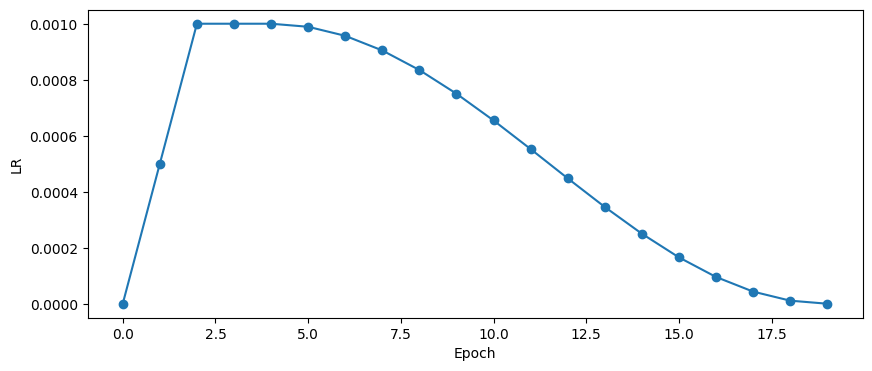

In [16]:
LR_START = 1e-7
LR_MAX = 1e-3
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 2
LR_SUSTAIN_EPOCHS = 2
EPOCHS = 20

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10,4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print('Learning Rate schedule : {:.3g} to {:3g} to {:3g}' . \
        format(lr_y[0], max(lr_y), lr_y[-1]))
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [17]:
from catboost import CatBoostRegressor

def preprocess_cat(df):
    df.county = df.county.astype(int)
    df.is_business = df.is_business.astype(int)
    df.product_type = df.product_type.astype(int)
    df.is_consumption = df.is_consumption.astype(int)
    df.segment = df.segment.astype(int)
    return df

In [26]:
# %%time
     
class Model:
    def __init__(self):
        self.conf = ModelConfig(auto_imputation=True,
                                auto_discrete=True,
                                auto_discard_unique=True,
                                categorical_columns='auto',
                                fixed_embedding_dim=False,
                                embeddings_output_dim=4,
                                embedding_dropout=0.3,
                                nets=['dnn_nets'],
                                dnn_params={
                                    'hidden_units': ((512, 0.3, True),
                                                     (256, 0.3, True)),
                                    'dnn_activation': 'relu',
                                },
                                stacking_op='add',
                                output_use_bias=False,
                                optimizer=CFG.optimizer,
                                task='regression',
                                loss='MeanAbsoluteError',
                                metrics='MeanAbsoluteError',
                                earlystopping_patience=1,
                                )
        
        self.lgb_params = {"n_estimators": 2500,
                           "learning_rate": 0.06,
                           "max_depth": 16,
                           "num_leaves": 500,
                           "reg_alpha": 3.5,
                           "reg_lambda": 1.5,
                           "colsample_bytree": 0.9,
                           "colsample_bynode": 0.6,
                           "min_child_samples": 50,
                           "random_state": 0,
                           "objective": "regression_l1",
                           "device": "gpu",
                           "n_jobs": 4,
                           "verbose": 1,
                           }
        
        ### add
        self.cb_params = {"colsample_bylevel": 0.878,
                          "task_type": "CPU",
                          "reg_lambda": 3.438,
                          "learning_rate": 0.042,
                          "max_depth": 10,
                          "min_data_in_leaf": 50,
                          "n_estimators": 2500,
                          "verbose": 1,
                          "objective": 'MAE',
                          "random_state": 0
                         }
        
        self.nn_model_consumption = DeepTable(config=self.conf)  
        self.nn_model_production = DeepTable(config=self.conf)
        
        self.lgb_model_consumption = lgb.LGBMRegressor(**self.lgb_params)
        self.lgb_model_production = lgb.LGBMRegressor(**self.lgb_params)
        
        ### add
        self.cb_model_consumption = CatBoostRegressor(**self.cb_params)
        self.cb_model_production = CatBoostRegressor(**self.cb_params)
        

    def fit(self, df_train_features):
        print('nn = '+str(CFG.nn))
        print('lgb = '+str(CFG.lgb))
        print('cb = '+str(CFG.cb))
        
        if CFG.nn == True:
            
            print('\n',"nn model consumption training.",'\n')
            mask = df_train_features["is_consumption"] == 1
            self.nn_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"],
#                 - df_train_features[mask]["target_48h"].fillna(0),
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
            # Avoid saving error
            with K.name_scope(CFG.optimizer.__class__.__name__):
                for i, var in enumerate(CFG.optimizer.weights):
                    name = 'variable{}'.format(i)
                    CFG.optimizer.weights[i] = tf.Variable(var, name=name)
            self.conf = self.conf._replace(optimizer=CFG.optimizer)   
            self.nn_model_production = DeepTable(config=self.conf)
            
            print('\n',"nn model production training.",'\n')
            mask = df_train_features["is_consumption"] == 0
            self.nn_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"],
#                 - df_train_features[mask]["target_48h"].fillna(0),
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
        if CFG.lgb == True:
            
            print('\n',"lgb model consumption training.")
            mask = df_train_features["is_consumption"] == 1
            self.lgb_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"],
#                 - df_train_features[mask]["target_48h"].fillna(0),
            )
        
            print('\n',"lgb model production training.",'\n')
            mask = df_train_features["is_consumption"] == 0
            self.lgb_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"],
#                 - df_train_features[mask]["target_48h"].fillna(0),
            )
        
        ### add
        if CFG.cb == True:
            
            df_train_features = preprocess_cat(df_train_features.copy())
            
            print('\n',"cb model consumption training.")
            mask = df_train_features["is_consumption"] == 1
            self.cb_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"],
#                 - df_train_features[mask]["target_48h"].fillna(0),
            )
        
            print('\n',"cb model production training.",'\n')
            mask = df_train_features["is_consumption"] == 0
            self.cb_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"],
#                 - df_train_features[mask]["target_48h"].fillna(0),
            )
        
        
    def plot_nn_model(self):
        if CFG.nn == True:
            return plot_model(self.nn_model_consumption.get_model().model)    

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))
        
#         if CFG.nn == True and CFG.lgb == True:
        assert CFG.nn == True and CFG.lgb == True and CFG.cb == True
            
#         print('\n',"nn & lgb model consumption prediction.",'\n')
        print('\n',"nn & lgb & cb model consumption prediction.",'\n')
        mask = df_features["is_consumption"] == 1
        predictions[mask.values] = np.clip( 0
#                 df_features[mask]["target_48h"].fillna(0).values
            + CFG.ens_weights['nn'] * (self.nn_model_consumption.predict(df_features[mask])[:,0])
            + CFG.ens_weights['lgb'] * (self.lgb_model_consumption.predict(df_features[mask]))
            + CFG.ens_weights['cb'] * (self.cb_model_consumption.predict(df_features[mask])),
            0,
            np.inf,
        )

#         print('\n',"nn & lgb model production prediction.",'\n')
        print('\n',"nn & lgb & cb model production prediction.",'\n')
        mask = df_features["is_consumption"] == 0
        predictions[mask.values] = np.clip( 0
#                 df_features[mask]["target_48h"].fillna(0).values
            + CFG.ens_weights['nn'] * (self.nn_model_production.predict(df_features[mask])[:,0])
            + CFG.ens_weights['lgb'] * (self.lgb_model_production.predict(df_features[mask]))
            + CFG.ens_weights['cb'] * (self.cb_model_consumption.predict(df_features[mask])),
            0,
            np.inf,
        )
        
#         elif CFG.nn == True and CFG.lgb == False:
            
#             print('\n',"nn model consumption prediction.",'\n')
#             mask = df_features["is_consumption"] == 1
#             predictions[mask.values] = np.clip( 0
# #                 df_features[mask]["target_48h"].fillna(0).values
#                 + self.nn_model_consumption.predict(df_features[mask])[:,0],
#                 0,
#                 np.inf,
#             )
            
#             print('\n',"nn model production prediction.",'\n')
#             mask = df_features["is_consumption"] == 0
#             predictions[mask.values] = np.clip( 0
# #                 df_features[mask]["target_48h"].fillna(0).values
#                 + self.nn_model_production.predict(df_features[mask])[:,0],
#                 0,
#                 np.inf,
#             )
            
#         elif CFG.nn == False and CFG.lgb == True:
            
#             print('\n',"lgb model consumption prediction.",'\n')
#             mask = df_features["is_consumption"] == 1
#             predictions[mask.values] = np.clip( 0
# #                 df_features[mask]["target_48h"].fillna(0).values
#                 + self.lgb_model_consumption.predict(df_features[mask]),
#                 0,
#                 np.inf,
#             )
            
#             print('\n',"lgb model production prediction.",'\n')
#             mask = df_features["is_consumption"] == 0
#             predictions[mask.values] = np.clip( 0
# #                 df_features[mask]["target_48h"].fillna(0).values
#                 + self.lgb_model_production.predict(df_features[mask]),
#                 0,
#                 np.inf,
#             )
            
#         else:
#             raise ValueError("No models has been trained.")
            
        return predictions
    

In [22]:
class CFG:
    nn = False #True
    lgb = False #True
    cb = True
    ens_weights = {'nn': 0.2, 'lgb': 0.4, 'cb': 0.4}
    epochs = 20
    batch_size = 512
    valid_size = 5e-2
    LR_Scheduler = [] #[LR]
    optimizer = AdamW(learning_rate=1e-3, weight_decay=9e-7)

In [20]:
%%time
model = Model()
model.fit(df_train_features)

nn = False
lgb = True
cb = False

 lgb model consumption training.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 16608
[LightGBM] [Info] Number of data points in the train set: 811400, number of used features: 82
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 75 dense feature groups (58.81 MB) transferred to GPU in 0.138126 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 107.327003

 lgb model production training. 

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 16605
[LightGBM] [Info] Number of data points in the train set: 811376, number of used features: 82
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 75 dense feature groups (58.81 MB) transferred to GPU in 0.042840 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.632000
CPU times: user 1h 15min 26s, sys: 28 s, total: 1h 15min 54s
Wall time: 21min 55s


In [21]:
joblib.dump(model.lgb_model_consumption, 'lgb_model_consumption.joblib')
joblib.dump(model.lgb_model_production, 'lgb_model_production.joblib')

['lgb_model_production.joblib']

In [ ]:
%%time
model = Model()
model.fit(df_train_features)

In [ ]:
nn_model_consumption = model.nn_model_consumption.get_model().model
nn_model_consumption.save('nn_model_consumption.h5')
nn_model_production = model.nn_model_production.get_model().model
nn_model_production.save('nn_model_production.h5')

In [ ]:
%%time
model = Model()
model.fit(df_train_features)

nn = False
lgb = False
cb = True

 cb model consumption training.
0:	learn: 408.0250176	total: 1.07s	remaining: 44m 44s
1:	learn: 396.1586679	total: 2.07s	remaining: 43m 8s
2:	learn: 385.3824825	total: 3.13s	remaining: 43m 28s
3:	learn: 373.3621618	total: 4.14s	remaining: 43m 1s
4:	learn: 360.6381330	total: 5.16s	remaining: 42m 53s
5:	learn: 353.3347014	total: 6.22s	remaining: 43m 5s
6:	learn: 340.9315315	total: 7.25s	remaining: 43m 2s
7:	learn: 329.9176843	total: 8.29s	remaining: 43m
8:	learn: 318.9751934	total: 9.29s	remaining: 42m 51s
9:	learn: 312.9188920	total: 10.3s	remaining: 42m 46s
10:	learn: 304.0228366	total: 11.4s	remaining: 42m 49s
11:	learn: 295.2002590	total: 12.4s	remaining: 42m 48s
12:	learn: 285.2684247	total: 13.4s	remaining: 42m 49s
13:	learn: 276.1190574	total: 14.5s	remaining: 42m 49s
14:	learn: 271.5501765	total: 15.5s	remaining: 42m 44s
15:	learn: 262.9730491	total: 16.6s	remaining: 42m 50s
16:	learn: 256.2226626	total: 17.6s	remaining: 42m 45s
17:	learn: 248.68

In [ ]:
### add
model.cb_model_consumption.save_model('cb_model_consumption', format='cbm')
model.cb_model_production.save_model('cb_model_production', format='cbm')

In [ ]:
clean_memory()
# model.plot_nn_model()

# Submit API

In [ ]:
mdir = '/kaggle/input/enefit-first-submit-jw-test'

lgb_model_consumption = joblib.load(f'{mdir}/lgb_model_consumption.joblib')
lgb_model_production = joblib.load(f'{mdir}/lgb_model_production.joblib')

from tensorflow.keras.models import load_model
# model_file = f'{mdir}/nn_model_production.h5'
# loaded_model = load_model(model_file)
model_production = load_model(f'{mdir}/nn_model_production.h5', custom_objects={'MultiColumnEmbedding':tf.keras.layers.Layer})
model_consumption = load_model(f'{mdir}/nn_model_consumption.h5', custom_objects={'MultiColumnEmbedding':tf.keras.layers.Layer})

In [ ]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [ ]:
%%time
for (
    df_test, 
    df_new_target, 
    df_new_client, 
    df_new_historical_weather,
    df_new_forecast_weather, 
    df_new_electricity_prices, 
    df_new_gas_prices, 
    df_sample_prediction
) in iter_test:

    data_storage.update_with_new_data(
        df_new_client=df_new_client,
        df_new_gas_prices=df_new_gas_prices,
        df_new_electricity_prices=df_new_electricity_prices,
        df_new_forecast_weather=df_new_forecast_weather,
        df_new_historical_weather=df_new_historical_weather,
        df_new_target=df_new_target
    )
    df_test = data_storage.preprocess_test(df_test)
    df_test = data_storage.run_test()
    
    df_test = features_generator.generate_features(df_test.df_data)
    df_test = df_test[df_test['target'].notnull()]
    df_test = add_custom_features(df_test)

    #이거 먼저 와야함, 예림 추가
    df_test['eic_count'] = df_test['eic_count'].fillna(method = 'bfill')
    df_test['installed_capacity'] = df_test['installed_capacity'].fillna(method = 'bfill')
    #add yelim
    df_test = DataTransformer(df_test)
    df_test = df_test.transform()
    #add joonyong
    df_test = TrainDataTransform(df_test)
    df_test = df_test.transform()
    ### drop county == 12 , prec_change Nan,  yelim added ####
    df_test = df_test[df_test['county'] != 12]
    df_test_features = df_test['precipitation_change'].fillna(method='bfill')
    
    prec = model.predict(df_test_features)
    
    
    df_sample_prediction["target"] = prec
    env.predict(df_sample_prediction)

In [ ]:
prec[:10]

In [ ]:
test = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/test.csv')
test.head()

In [ ]:
train = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv')
train.head()